<h1><center>Stroke Prediction</center></h1>
<center>September 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Notebook Preparation
    1. Motivation and Objectives
    1. Dataset
1. Data Cleaning
    1. Duplicate rows
    1. Datatypes
    1. Unique values
    1. Missing values
1. EDA
    1. Distribution
    1. Distribution according to target label
    1. Missing Values
    1. Statistic Inference
        1. Target Population
        2. Transform 'AnnualIncome'
       3. Hypothesis Testing
1. Data Formatting
1. Preprocessing
    1. Transformations
    1. Data Splitting
1. Models
    1. Apply various models
    1. Ensemble - Voting
1. Conclusion
1. Improvements

# 1. Project Introduction

## 1.1. Notebook Preparation

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eda import *

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## 1.2. Motivations and Objectives

This project's objectives are: 
<br><br>
1. Practice performing EDA.
2. Practice applying statistical inference procedures.
3. Practice using various types of machine learning models.
4. Practice building ensembles of machine learning models.
5. Practice deploying machine learning models.

## 1.3. Dataset

Objective: Brief overview of our dataset, including the features and label

The dataset was downloaded from Kaggle, [Stroke_Prediction_Data](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
,<br>
on 10 September 2024. It will be used to predict whether a patient is likely
 <br> to get a stroke. <br>
The data contains 11 clinical features, like gender, age, smoking status, <br>
etc, that help describe each patient.

Features: <br>
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
<br>

Label: <br>
stroke: 1 if the patient had a stroke or 0 if not <br>

In [3]:
stroke_data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
display(stroke_data.head())
shape = stroke_data.shape
print(f'Number of rows: {shape[0]}\nNumber of columns: {shape[1]}')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Number of rows: 5110
Number of columns: 12


# 2.  Data cleaning
Objective:
1. Closer look at the values that consist of our data
2. Look out for duplicates, and missing and/or unusual values

## 2.1. Duplicate rows

In [4]:
print(stroke_data.id.duplicated().any())

False


After confirming there is no duplicated id number/cases, since id number 
should not be relevant information to base our prediction on, we can remove it.

In [5]:
stroke_data = stroke_data.drop(columns=['id'])

## 2.2. Datatypes

In [6]:
datatype_data = stroke_data.dtypes
datatype_data

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Certain features have unexpected datatypes, like age, hypertension, and 
heart_disease. Looking into the values itself will help clarify data types.

## 2.3. Unique values

In [7]:
stroke_data.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Some features have unexpected amount of unique values. Looking into the 
values itself will help.<br>

In [8]:
for column in stroke_data.columns:
    df = stroke_data[column].value_counts()
    display(df)

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: count, Length: 104, dtype: int64

hypertension
0    4612
1     498
Name: count, dtype: int64

heart_disease
0    4834
1     276
Name: count, dtype: int64

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

avg_glucose_level
93.88     6
91.68     5
91.85     5
83.16     5
73.00     5
         ..
111.93    1
94.40     1
95.57     1
66.29     1
85.28     1
Name: count, Length: 3979, dtype: int64

bmi
28.7    41
28.4    38
26.7    37
27.6    37
26.1    37
        ..
48.7     1
49.2     1
51.0     1
49.4     1
14.9     1
Name: count, Length: 418, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

stroke
0    4861
1     249
Name: count, dtype: int64

Looking more into work_type registered as 'children', as the difference 
between 'children' and 'Never_worked' is not clear.

In [9]:
stroke_data[stroke_data.work_type=='children'].age.describe()

count    687.000000
mean       6.841339
std        4.533364
min        0.080000
25%        2.000000
50%        6.000000
75%       11.000000
max       16.000000
Name: age, dtype: float64

All labeled as children are <= 16 years old.

In [10]:
stroke_data[(stroke_data.age<=16)]['work_type'].value_counts()

work_type
children         687
Private           85
Never_worked      12
Self-employed      9
Govt_job           3
Name: count, dtype: int64

It is clear that not all under 16 year olds are labeled as 'children'. Some 
are 'Never_worked', and some are working. It is unclear why only part is 
labeled as 'children'. <br>However, it since this
 feature is to state their work status and 'children' in this context would 
 mean not working, we can consolidate 'children' into 'Never_worked'. <br>
 This would ensure consistency across all age groups, without losing the age
  information, as it is in the 'age' column.

In [11]:
stroke_data.loc[stroke_data['work_type'] == 'children', 'work_type'] = \
    'Never_worked'

## 2.4. Missing values

In [12]:
missing_values(df=stroke_data)

,Column,Missing Values,Percentage Missing
gender,gender,0,0.00
age,age,0,0.00
hypertension,hypertension,0,0.00
heart_disease,heart_disease,0,0.00
ever_married,ever_married,0,0.00
work_type,work_type,0,0.00
Residence_type,Residence_type,0,0.00
avg_glucose_level,avg_glucose_level,0,0.00
bmi,bmi,201,3.93
smoking_status,smoking_status,0,0.00


To properly impute missing values, it is necessary to first understand the 
sampling population and if the missing values belong to a specific subset of
 sampling population.

In [13]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Data Cleaning Insights:</b><br>
    1. There are no duplicated rows, and each row is identified by a unique ID.<br>
    2. The feature 'id' is irrelevant to our stroke prediction, so it was removed.<br>
    3. Consolidated 'children' work type to 'Never_worked'. <br>
    4. All missing values come from the 'bmi' feature, and further analysis 
    is needed to determine proper imputation methods.
</div>
''')

# 3. EDA

Objectives:
1. Data distribution
2. Check and handle outliers, missing values
3. Comparison between data with and without stroke
4. Understand how our data was collected and possible bias
5. Understand how do columns related with each other - correlation
6. 

## 3.1. Distribution

Identify features, label, and different feature types.

In [14]:
target_name = 'stroke'
data, target = (stroke_data.drop(columns=[target_name]), 
                stroke_data[target_name])

In [15]:
categorical_columns_selector = selector(dtype_exclude='float64')
numerical_columns_selector = selector(dtype_include='float64')

categorical_columns = categorical_columns_selector(data)
numerical_columns = numerical_columns_selector(data)

**Numerical Features**

In [16]:
data[numerical_columns].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


Plotting boxplot over violin plot for numerical features to have a visual 
understanding of the overall distribution, range, and outliers.

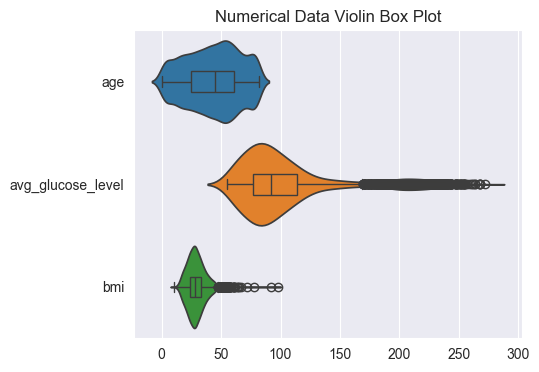

In [17]:
plt.figure(figsize=(5,4))
violin_boxplot(data=data, columns=numerical_columns, title='Numerical Data '
                                                           'Violin Box '
                                                           'Plot')
plt.show()

**Categorical Features**

In [18]:
categorical_columns

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

Represent categorical features in barplots, visualize unique values for each
 feature and their distribution in percentage.

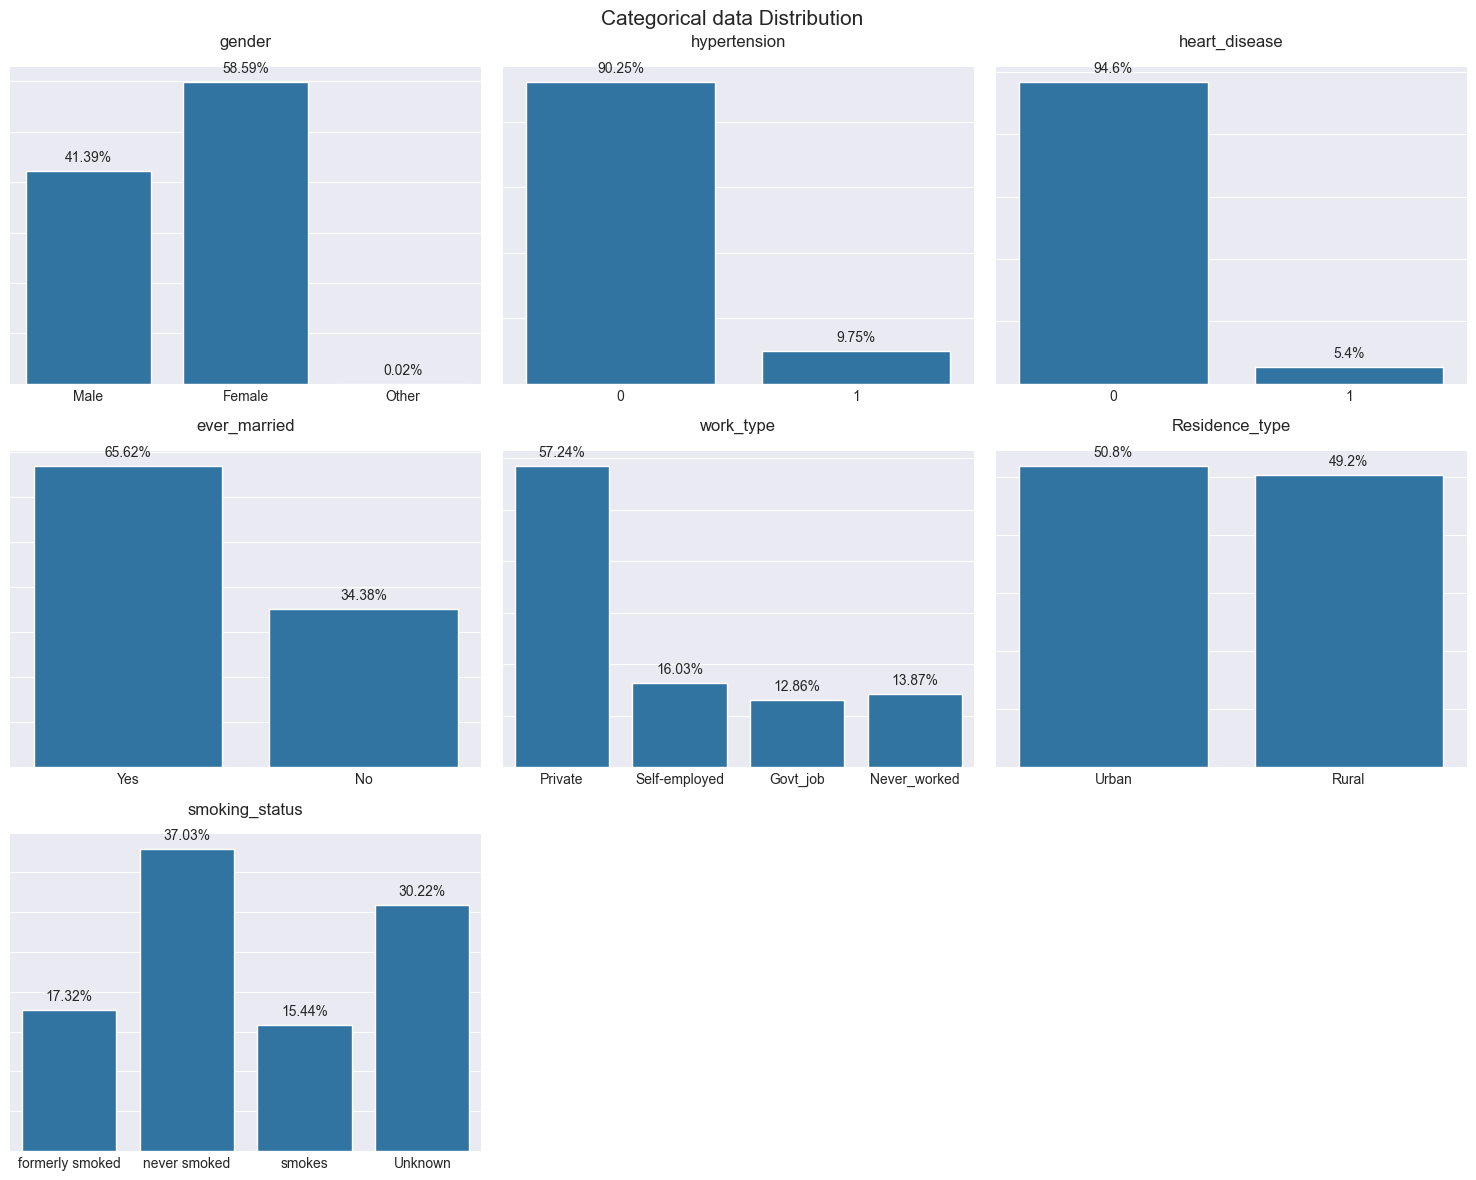

In [19]:
percentage_subplots(data=data, columns=categorical_columns, title='Categorical '
                                                             'data '
                                                             'Distribution',
               nrows=3, ncols=3)

**Target Variable**

Target variable and its distribution in percentage.

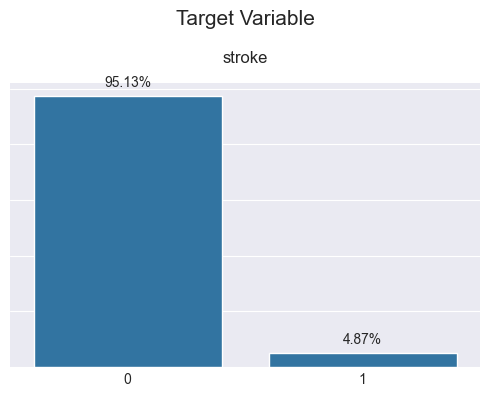

In [20]:
percentage_subplots(data=stroke_data, columns=['stroke'], title='Target Variable')

In [21]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Distribution Insights:</b><br>
    <i>numerical features...</i><br>
    1. Numerical features show very different ranges of values, signalling an 
    importance in scaling in future feature engineering.<br>
    2. Average Glucose Level has the most outliers, which can be justified 
    by the bimodal distribution. This could contain relevant information to 
    our target prediction.
    <br>
    3. 'age' includes children less than 1 year old, justifies why the 
    datatype is float.<br><br>
    
    <i>for categorical features...</i><br>
    4. Inconsistent labeling among categorical features, preprocessing 
    required before applying learning model.<br>
    5. Outlier responses in 'gender'.<br><br>
    
    <i>and the target variable...</i><br>
    6. Imbalanced dataset, with only 4.87% responding positively to stroke. 
    <br>
</div>
''')

In [22]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Target Population:</b><br>
    The target population is mostly likely the group of people who are 
    concerned about their probability of getting a stroke.<br><br>
    
    <b>Sampling Population:</b><br>
    Our data's distribution describes our sampling population. 
    <br><br>
    
    <b>Potential Bias:</b><br>
    The data's collection method and answer's definition are unknown. 
    If the sampling population is not representative of the target 
    population, there might be significant biases. 
    <br>
</div>
''')

## 3.2. Distribution according to target label
Objective:<br>
Plot data distribution by target variable to understand if the populations 
show clear differences in their characteristics.

**Numerical Features** <br>
Cases with stroke

In [23]:
stroke_data[stroke_data.stroke == 1][numerical_columns].describe()

,age,avg_glucose_level,bmi
count,249.000000,249.000000,209.000000
mean,67.728193,132.544739,30.471292
std,12.727419,61.921056,6.329452
min,1.320000,56.110000,16.900000
25%,59.000000,79.790000,26.400000
50%,71.000000,105.220000,29.700000
75%,78.000000,196.710000,33.700000
max,82.000000,271.740000,56.600000


Cases without stroke

In [24]:
stroke_data[stroke_data.stroke == 0][numerical_columns].describe()

,age,avg_glucose_level,bmi
count,4861.000000,4861.000000,4700.000000
mean,41.971545,104.795513,28.823064
std,22.291940,43.846069,7.908287
min,0.080000,55.120000,10.300000
25%,24.000000,77.120000,23.400000
50%,43.000000,91.470000,28.000000
75%,59.000000,112.830000,33.100000
max,82.000000,267.760000,97.600000


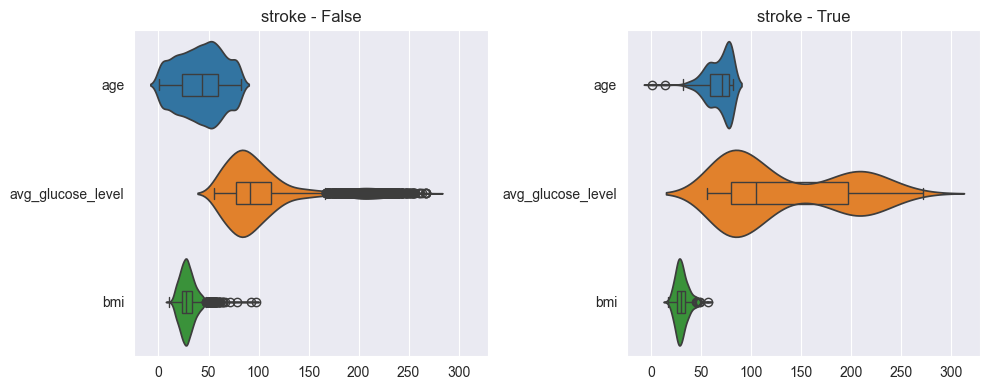

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)

violin_boxplot(data=stroke_data[stroke_data.stroke == 1], 
               columns=numerical_columns, title='stroke - True', ax=axes[1])
violin_boxplot(data=stroke_data[stroke_data.stroke == 0], 
               columns=numerical_columns, title='stroke - False', ax=axes[0])

plt.tight_layout()
plt.show()

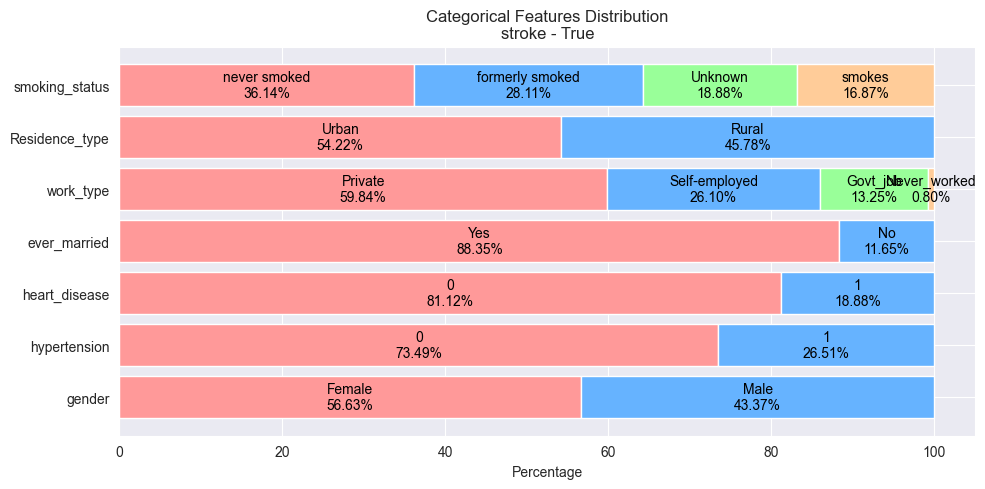

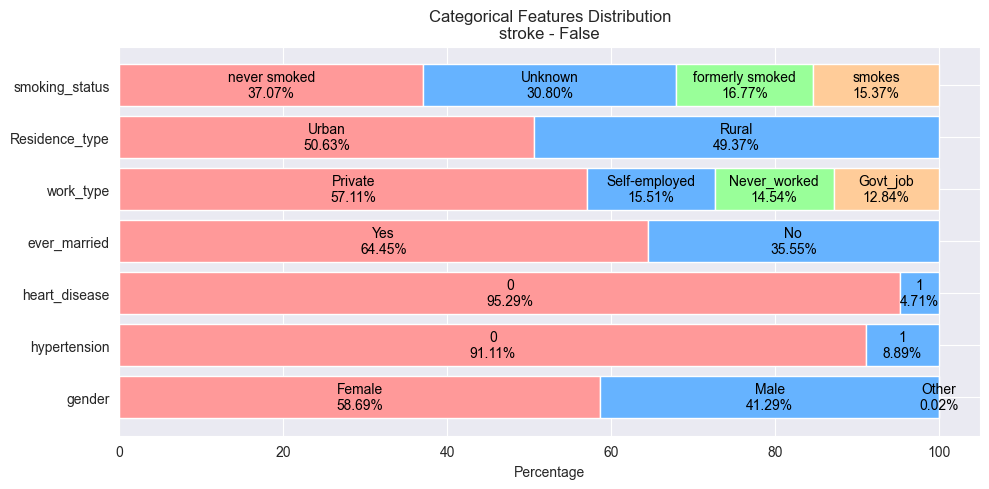

In [26]:

stacked_horizontal_feature_distribution(data=stroke_data[stroke_data.stroke == 1], 
                                        columns=categorical_columns, 
                                        title='Categorical Features '
                                              'Distribution\nstroke'
                                              ' - True') 
stacked_horizontal_feature_distribution(data=stroke_data[stroke_data.stroke == 0], 
               columns=categorical_columns, title='Categorical Features '
                                              'Distribution\nstroke - False')

In [27]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Distribution Insights:</b><br>
    Plots show visually significant difference between population with and 
    without stroke.<br><br>
    <i>numerical features...</i><br>
    1. With stroke consists of a higher age and higher bmi mean, with a 
    smaller standard deviation. Considering the sample size is smaller for 
    cases with stroke, it is very possible that these 2 features are highly 
    predictive of our target variable.<br>
    2. Average Glucose Level for cases with stroke has both the higher mean 
    and higher standard deviation. This is likely due to its clear 
    bimodal distribution. <br><br>

    
    <i>for categorical features...</i><br>
    3.  Smoking status, residence type, and gender seem similar among both 
    target labels. This could mean these features do not contain predictive 
    information for the target variable.<br>
    4. Work type, ever married, heart disease, and hypertension show 
    more different distribution.<br>
    5. Knowing that age seem to be an important factor, important to note 
    that some other features are also highly influenced by age. For example,
     it is more likely for the older age group to have a higher ratio to have 
    ever been married, or worked. <br>
</div>
''')

## 3.3. Missing values

Objective: <br>
All missing values come from the 'bmi' feature. Determine proper treatment.

Plot data distribution of cases with missing bmi values. Compare to the 
original data distributions, and check if there is a clear difference 
with missing bmi cases.

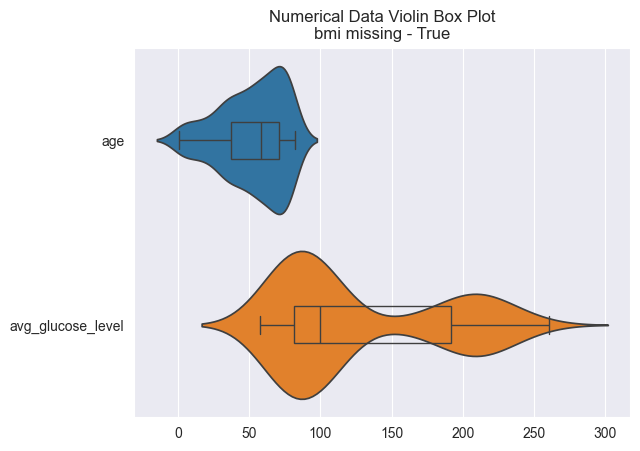

In [28]:
violin_boxplot(data=stroke_data[stroke_data.bmi.isnull()], 
               columns=['age', 'avg_glucose_level'],
               title='Numerical Data Violin Box Plot\nbmi missing - True')

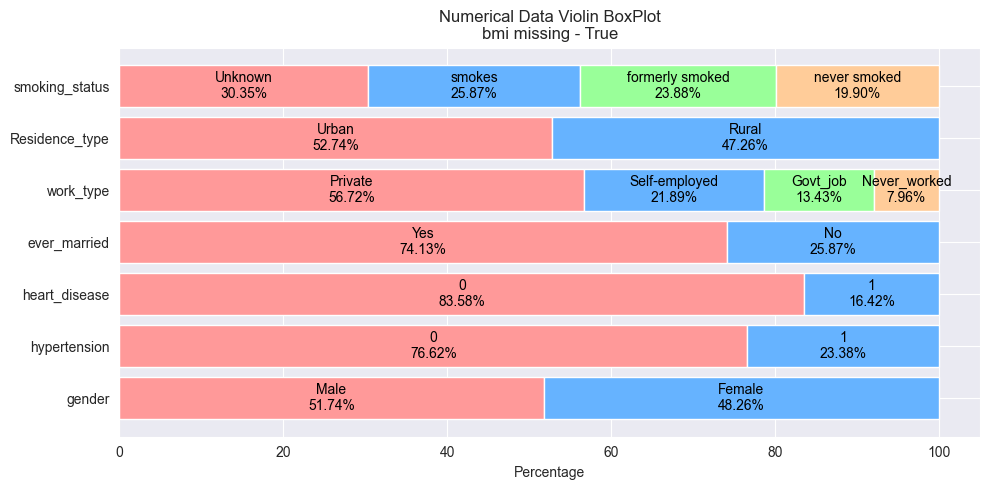

In [29]:
stacked_horizontal_feature_distribution(data=stroke_data[stroke_data.bmi.isnull()], 
                                        columns=categorical_columns, 
                                        title='Numerical Data Violin Box'
                                              'Plot\nbmi missing - True')

The distribution for both numerical and categorical do not seem to represent
 a different subpopulation. <br>
Check if bmi is correlated with other features, this can help choose what 
values to impute.

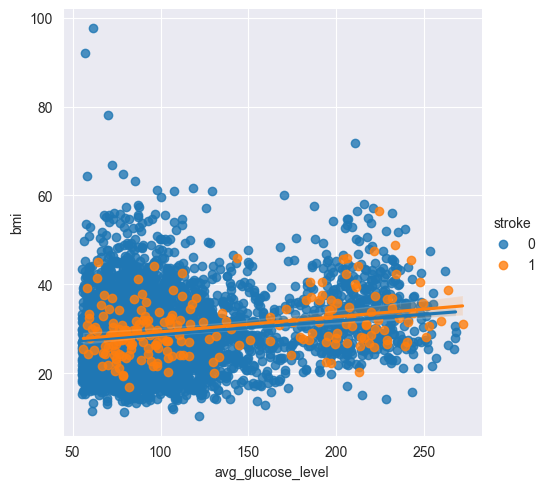

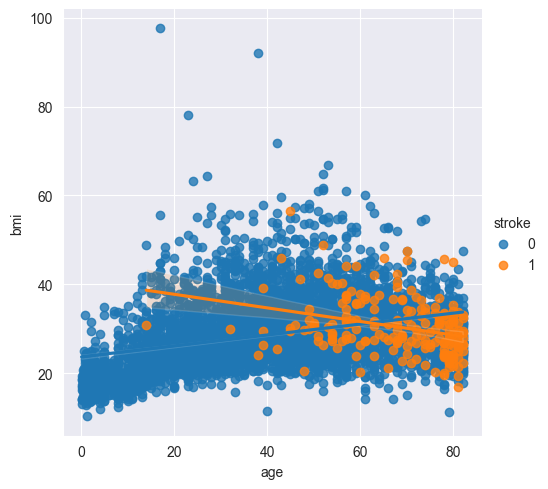

In [30]:
sns.lmplot(data=stroke_data, x='avg_glucose_level', y='bmi', hue='stroke')
sns.lmplot(data=stroke_data, x='age', y='bmi', hue='stroke')

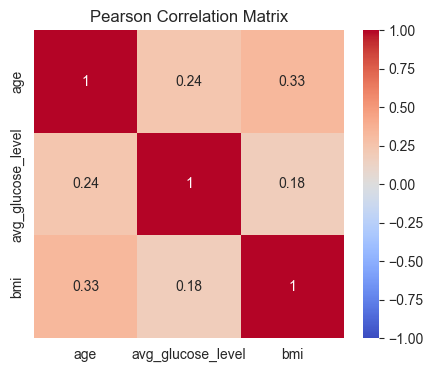

In [31]:
correlation_matrix = stroke_data[numerical_columns].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            center=0)
plt.title('Pearson Correlation Matrix')
plt.show()

From the plots above: <br>
1. Correlation between numerical features are very weak to weak.
2. bmi values could be imputed by linear interpolation from other numerical 
features. Since correlation coefficient is low, using mean imputation or 
leaving it as null values is also good enough.

In [32]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Missing Values Insights:</b><br>
    After some analysis, it is understood that missing values do not belong 
    to any specific subpopulation. The subset of data which has missing 
    'bmi' values do not show a drastically different distribution in other 
    features. Therefore, imputing with the mean value, or even keeping it as
    null value during the preprocessing step will be enough.
</div>
''')

# 4. Data Formatting
Objective: Only decision tree based models will be used in this project, 
so the following formatting is only to be able to draw a tree visually, 
providing with better interpretability in the end.

Remove all empty values in values.

In [33]:
stroke_data['smoking_status'] =(
    stroke_data['smoking_status'].replace(' ', '_', regex=True))
stroke_data['smoking_status'].unique()

array(['formerly_smoked', 'never_smoked', 'smokes', 'Unknown'],
      dtype=object)

Set empty values to 0 

In [34]:
stroke_data['bmi'] = stroke_data['bmi'].fillna(0)

# 5. Preprocessing
Objective:<br>
Prepare preprocesses in order to apply learning models. <br>
1. Data splitting
2. Data transformation and encoding

## 5.1. Data Splitting

In [35]:
X = data
y = target

Split data into train, validation, and test sets. With a ratio of 20% being 
the test set.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=0)

To evaluate variability of our estimation of the performance, cross 
validation will be used. More specifically, ShuffleSplit for the train and 
validation sets, as this is a better option for imbalanced datasets.

In [37]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

## 5.2. Data Transformation

As only models based on decision trees will be used in this project, 
transformations like scaling and normalizing will not be needed. Only encoding 
categorical columns will be necessary.

**Define columns**

In [38]:
multicat_columns = ['gender', 'work_type', 'smoking_status']
binary_columns = ['hypertension', 'heart_disease', 'ever_married', 
                 'residence_type']

**Define preprocessors for each type of data**<br>
LabelEncoder does not work within a pipeline, write our own function.

In [39]:
def binary_label_encoding(X):
    return X.applymap(lambda x: 1 if x in ['Yes', 'Urban', True] else 0)

multicat_preprocessor = OneHotEncoder(handle_unknown='ignore')
binary_preprocessor = FunctionTransformer(binary_label_encoding)

**Bundle preprocessing for all data**

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', multicat_preprocessor, multicat_columns),
        ('binary', binary_preprocessor, binary_columns),
        ('passthrough', 'passthrough', numerical_columns)
    ]
)

# 6. Models
Objective: <br>
1. Apply and hypertune machine learning models
2. Access and select the best model

## 6.1. Apply and Fit models
Fit and access the base

In [41]:
random_forest = RandomForestClassifier(random_state=0)
clf_xbg = xgb.XGBClassifier(objective='binary:logistic', missing=None, 
                            random_state=0)
clf_lgb = lgb.LGBMClassifier(objective='binary:logistic', random_state=0)

**Pipeline**

In [42]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', random_forest)
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf_xbg)
])

pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf_lgb)
])

**Hyperparameter Tuning**

In [43]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 5]
}

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

param_grid_lgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [31, 50]
}

In [44]:
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv, scoring='accuracy', verbose=2)
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=cv, scoring='accuracy', verbose=2)
grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=cv, scoring='accuracy', verbose=2)

**Fit and Train models**

In [45]:
grid_rf.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.0s
[CV] END classifier__max_depth=5, classifier__min_

ValueError: 
All the 120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'residence_type'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/utils/_indexing.py", line 361, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'residence_type'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.2.5/.venv/lib/python3.9/site-packages/sklearn/utils/_indexing.py", line 369, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")

print("Random Forest Performance:")
evaluate_model(grid_rf, X_test, y_test)

print("\nXGBoost Performance:")
evaluate_model(grid_xgb, X_test, y_test)

print("\nLightGBM Performance:")
evaluate_model(grid_lgb, X_test, y_test)

# 12. Print best parameters for each model
print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best Parameters for XGBoost:", grid_xgb.best_params_)
print("Best Parameters for LightGBM:", grid_lgb.best_params_)

## Models
1. XGBoost
2. LightBGM
3. Single decision tree - sklearn
4. Bagging - sklearn
5. Random Forest - sklearn

Draw Tree in the end for the best performance model

# 7. Deploy the machine learning model

# Improvement

1. Our data is imbalanced and can show certain sampling biases. This will 
increase the model's incorrect predictions. A more representative and 
careful data collection with proper definitions will help.
2. More related data about symptoms/discomfort/previous medical history can 
help develop a model that is better adjusted for the use case.
3. T-test and Chi-square test to thoroughly test differences between stroke/no 
stroke and bmi subpopulation.
4. Try resampling techniques, like oversampling and under sampling, to address 
imbalanced data.
5. 